<a href="https://colab.research.google.com/github/Mirolla03/SQL-datawarehouse-project/blob/main/water_leakage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
df = pd.read_csv("/content/Final_SCADA.csv")

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

# Drop timestamp for training
X_df = df.drop(columns=["Timestamp"])


##Handling missing data

In [7]:
# forward fill then back fill (safe for time-series)
X_df = X_df.ffill().bfill()

# If still missing:
X_df = X_df.fillna(0)


##Train/Test split

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.values).astype(np.float32)

print(X_scaled.shape)   # (210241, num_sensors)


(210240, 119)


In [9]:
split = int(len(X_scaled) * 0.7)

X_train = X_scaled[:split]
X_test  = X_scaled[split:]


##Normalization

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# 1) Load
df = pd.read_csv("/content/Final_SCADA.csv")

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

# 2) Separate timestamp
timestamps = df["Timestamp"].copy()

X_df = df.drop(columns=["Timestamp"])

# 3) Fill missing values
X_df = X_df.ffill().bfill().fillna(0)

# 4) Time-based split (VERY important)
split = int(len(X_df) * 0.7)

X_train_df = X_df.iloc[:split]
X_test_df  = X_df.iloc[split:]

ts_train = timestamps.iloc[:split]
ts_test  = timestamps.iloc[split:]

print("Train rows:", len(X_train_df))
print("Test rows:", len(X_test_df))

# 5) Fit scaler on TRAIN ONLY
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values).astype(np.float32)

# 6) Transform test using same scaler
X_test_scaled = scaler.transform(X_test_df.values).astype(np.float32)

# 7) Save scaler
joblib.dump(scaler, "scaler.pkl")

print("Train scaled shape:", X_train_scaled.shape)
print("Test scaled shape:", X_test_scaled.shape)


Train rows: 147168
Test rows: 63072
Train scaled shape: (147168, 119)
Test scaled shape: (63072, 119)


##Windowing

In [13]:
#Create window dataset
import tensorflow as tf

WINDOW = 48
STRIDE = 5
BATCH_SIZE = 64

def make_tf_windows(data, window_size=48, stride=5, batch_size=64, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(data)

    ds = ds.window(window_size, shift=stride, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if shuffle:
        ds = ds.shuffle(2000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [14]:
#Create train/test datasets
train_ds = make_tf_windows(X_train_scaled, WINDOW, STRIDE, BATCH_SIZE, shuffle=True)
test_ds  = make_tf_windows(X_test_scaled,  WINDOW, STRIDE, BATCH_SIZE, shuffle=False)


In [15]:
for batch in train_ds.take(1):
    print(batch.shape)


(64, 48, 119)


##Building the model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

WINDOW = 48
num_sensors = 119   # from your data


In [18]:
inputs = keras.Input(shape=(WINDOW, num_sensors))

# Encoder
x = layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
x = layers.MaxPooling1D(2, padding="same")(x)   # 48 -> 24

x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling1D(2, padding="same")(x)   # 24 -> 12

x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)  # bottleneck

# Decoder
x = layers.UpSampling1D(2)(x)   # 12 -> 24
x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)

x = layers.UpSampling1D(2)(x)   # 24 -> 48
x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)

outputs = layers.Conv1D(num_sensors, 3, padding="same")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 119)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 64)         │        22,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 48, 119)        │        22,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,383 (239.78 KB)

 Trainable params: 61,383 (239.78 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
train_ds_ae = train_ds.map(lambda x: (x, x))
test_ds_ae  = test_ds.map(lambda x: (x, x))


In [21]:
#Training
history = model.fit(
    train_ds_ae,
    epochs=20,
    validation_data=test_ds_ae
)



Epoch 1/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - loss: 0.5213 - val_loss: 0.5330
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.4129 - val_loss: 0.5259
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.3984 - val_loss: 0.5184
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - loss: 0.3903 - val_loss: 0.5107
Epoch 5/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3864 - val_loss: 0.4944
Epoch 6/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.3820 - val_loss: 0.4725
Epoch 7/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.3778 - val_loss: 0.4700
Epoch 8/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3750 - val_loss: 0.4582
Epoch 9/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3726 - val_loss: 0.4535
Epoch 10/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 142s 308ms/step - loss: 0.3710 - val_loss: 0.4525
Epoch 11/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - loss: 0.3702 - val_loss: 0.4515
Epoch 12/20
460/460 ━━━━━━━━

##Plotting Fake Anomalies/Spikes

In [41]:
import numpy as np

# Copy test data so we don’t overwrite original
X_test_spiked = X_test_scaled.copy()

# Number of anomalies to inject
num_anomalies = 10

# Randomly pick start indices for anomalies
np.random.seed(42)
anomaly_indices = np.random.randint(low=0, high=X_test_spiked.shape[0]-5, size=num_anomalies)

# Inject spikes: add a large value to some sensors for 5 consecutive rows
for idx in anomaly_indices:
    # Example: spike in first 5 sensors (you can choose any sensor)
    X_test_spiked[idx:idx+5, :5] += np.random.uniform(5, 10, size=(5, 5))  # large spike


In [42]:
WINDOW = 48
STRIDE = 5
BATCH_SIZE = 64

# TensorFlow dataset for spiked test
test_ds_spiked = tf.data.Dataset.from_tensor_slices(X_test_spiked)
test_ds_spiked = test_ds_spiked.window(WINDOW, shift=STRIDE, drop_remainder=True)
test_ds_spiked = test_ds_spiked.flat_map(lambda w: w.batch(WINDOW))
test_ds_spiked = test_ds_spiked.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_spiked_ae = test_ds_spiked.map(lambda x: (x, x))


In [43]:
# Predict on spiked test
test_pred_spiked = model.predict(test_ds_spiked_ae, verbose=0)

# Flatten dataset to compute MSE
test_windows_flat = np.concatenate([x for x, y in test_ds_spiked_ae], axis=0)
test_mse_spiked = np.mean(np.square(test_windows_flat - test_pred_spiked.reshape(-1, WINDOW, num_sensors)), axis=(1,2))

# Aligned timestamps
aligned_timestamps_spiked = ts_test[WINDOW-1::STRIDE]


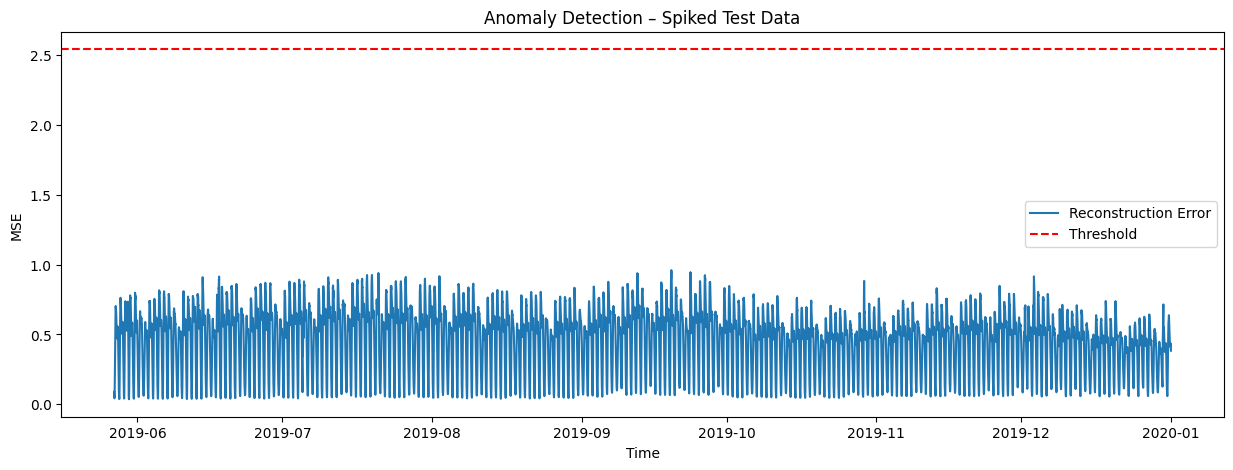

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(aligned_timestamps_spiked, test_mse_spiked, label="Reconstruction Error")
plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Time")
plt.ylabel("MSE")
plt.title("Anomaly Detection – Spiked Test Data")
plt.legend()
plt.show()


##fake anomalies2

In [45]:
# Copy test data
X_test_spiked = X_test_scaled.copy()

# Number of anomaly windows to inject
num_anomalies = 5
np.random.seed(42)
anomaly_indices = np.random.randint(0, X_test_spiked.shape[0]-10, num_anomalies)

# Inject *very large* spikes in scaled space (e.g., +10 to +15 stds)
for idx in anomaly_indices:
    # Spike across first 5 sensors
    X_test_spiked[idx:idx+5, :5] += np.random.uniform(10, 15, size=(5,5))


In [46]:
# TensorFlow dataset
test_ds_spiked = tf.data.Dataset.from_tensor_slices(X_test_spiked)
test_ds_spiked = test_ds_spiked.window(WINDOW, shift=STRIDE, drop_remainder=True)
test_ds_spiked = test_ds_spiked.flat_map(lambda w: w.batch(WINDOW))
test_ds_spiked = test_ds_spiked.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_spiked_ae = test_ds_spiked.map(lambda x: (x, x))

# Predict
test_pred_spiked = model.predict(test_ds_spiked_ae, verbose=0)

# Compute MSE per window
test_windows_flat = np.concatenate([x for x, y in test_ds_spiked_ae], axis=0)
test_mse_spiked = np.mean(np.square(test_windows_flat - test_pred_spiked.reshape(-1, WINDOW, num_sensors)), axis=(1,2))

# Align timestamps
aligned_timestamps_spiked = ts_test[WINDOW-1::STRIDE]


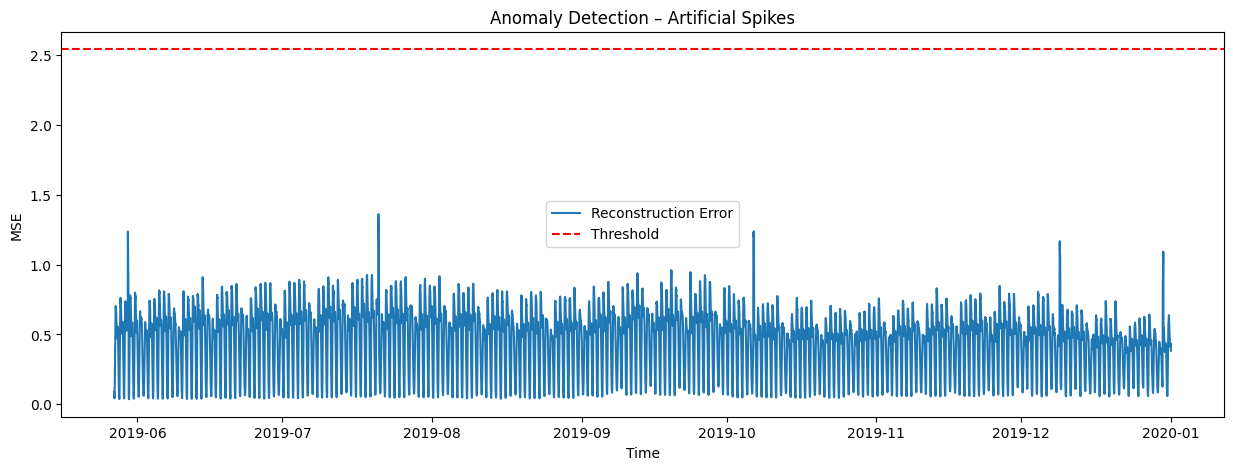

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(aligned_timestamps_spiked, test_mse_spiked, label="Reconstruction Error")
plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Time")
plt.ylabel("MSE")
plt.title("Anomaly Detection – Artificial Spikes")
plt.legend()
plt.show()


Current threshold: 0.9097461


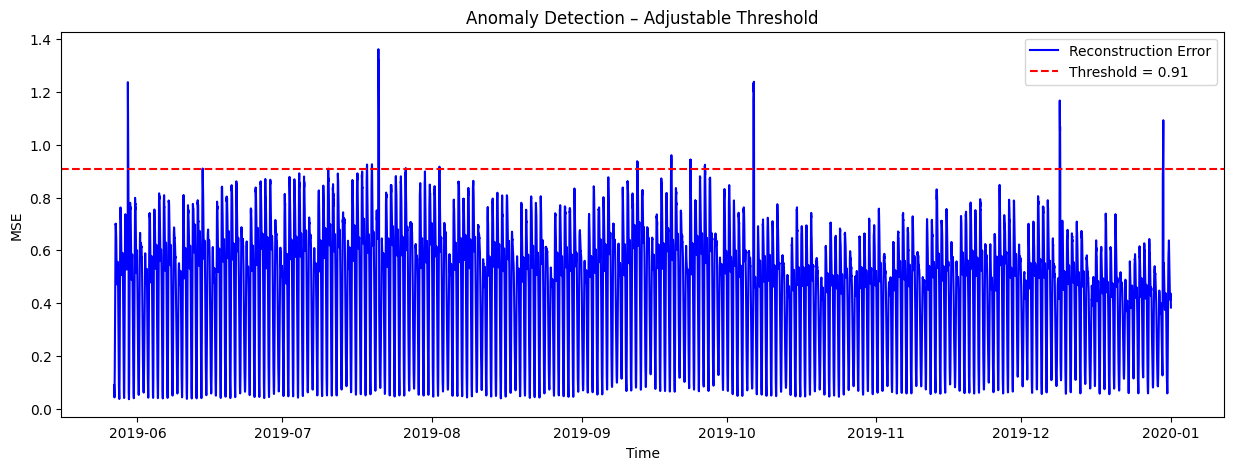

In [52]:
import matplotlib.pyplot as plt

# You can change this value to see spikes clearly
threshold = np.percentile(train_mse, 30)  # try 85, 90, etc.
print("Current threshold:", threshold)

plt.figure(figsize=(15,5))
plt.plot(aligned_timestamps_spiked, test_mse_spiked, label="Reconstruction Error", color='blue')
plt.axhline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold:.2f}")

plt.xlabel("Time")
plt.ylabel("MSE")
plt.title("Anomaly Detection – Adjustable Threshold")
plt.legend()
plt.show()


##Anomaly Detection

In [22]:
#get reconstruction error
# Predict on train and test
train_pred = model.predict(train_ds_ae, verbose=0)
test_pred  = model.predict(test_ds_ae, verbose=0)

# Compute MSE per window
train_mse = np.mean(np.square(np.concatenate([x for x, y in train_ds_ae], axis=0) - train_pred.reshape(-1, WINDOW, num_sensors)), axis=(1,2))
test_mse  = np.mean(np.square(np.concatenate([x for x, y in test_ds_ae],  axis=0) - test_pred.reshape(-1, WINDOW, num_sensors)), axis=(1,2))

print("Train MSE example:", train_mse[:5])
print("Test MSE example:", test_mse[:5])


Train MSE example: [2.202957   0.45652062 0.58021945 1.2111071  0.80146873]
Test MSE example: [0.08860953 0.07182512 0.05682411 0.04764532 0.04282017]


In [53]:
threshold = np.percentile(train_mse, 30)
print("Anomaly threshold:", threshold)


Anomaly threshold: 0.9097461


In [54]:
anomalies = test_mse > threshold
print("Number of anomaly windows:", np.sum(anomalies))


Number of anomaly windows: 30


In [55]:
# Each window corresponds to the last timestamp in that window
test_timestamps = ts_test[WINDOW-1:].iloc[::STRIDE]  # match stride

anomaly_times = test_timestamps[anomalies]
print("Anomaly timestamps:\n", anomaly_times.head(10))


Anomaly timestamps:
 152495   2019-06-14 11:55:00
162290   2019-07-18 12:10:00
162295   2019-07-18 12:35:00
162300   2019-07-18 13:00:00
162580   2019-07-19 12:20:00
162585   2019-07-19 12:45:00
162590   2019-07-19 13:10:00
162595   2019-07-19 13:35:00
164605   2019-07-26 13:05:00
166615   2019-08-02 12:35:00
Name: Timestamp, dtype: datetime64[ns]


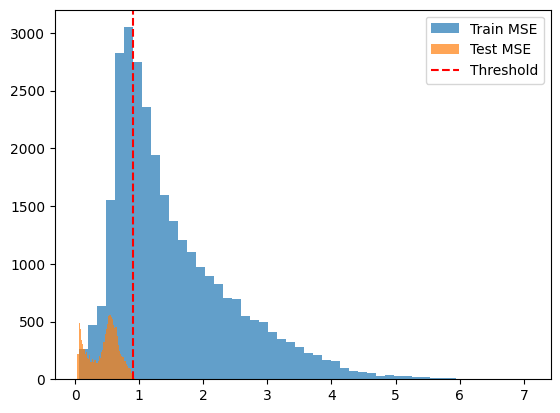

In [56]:
import matplotlib.pyplot as plt

plt.hist(train_mse, bins=50, alpha=0.7, label="Train MSE")
plt.hist(test_mse, bins=50, alpha=0.7, label="Test MSE")
plt.axvline(threshold, color="r", linestyle="--", label="Threshold")
plt.legend()
plt.show()


In [57]:
train_ds_ae_no_shuffle = train_ds.map(lambda x: (x, x))
train_pred = model.predict(train_ds_ae_no_shuffle, verbose=0)
train_mse = np.mean(np.square(np.concatenate([x for x, y in train_ds_ae_no_shuffle], axis=0) - train_pred.reshape(-1, WINDOW, num_sensors)), axis=(1,2))
threshold = np.percentile(train_mse, 95)


In [37]:
threshold = np.percentile(train_mse, 85)


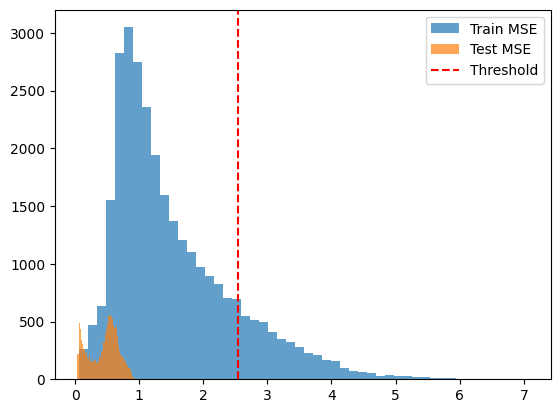

In [38]:
import matplotlib.pyplot as plt

plt.hist(train_mse, bins=50, alpha=0.7, label="Train MSE")
plt.hist(test_mse, bins=50, alpha=0.7, label="Test MSE")
plt.axvline(threshold, color="r", linestyle="--", label="Threshold")
plt.legend()
plt.show()


In [39]:
# test windows were made with:
# WINDOW = 48, STRIDE = 5
WINDOW = 48
STRIDE = 5

# Take the last timestamp of each window
aligned_timestamps = ts_test[WINDOW-1::STRIDE]  # start at 48th row, jump by stride

print("Aligned timestamps:", len(aligned_timestamps))
print("Test MSE:", len(test_mse))


Aligned timestamps: 12605
Test MSE: 12605


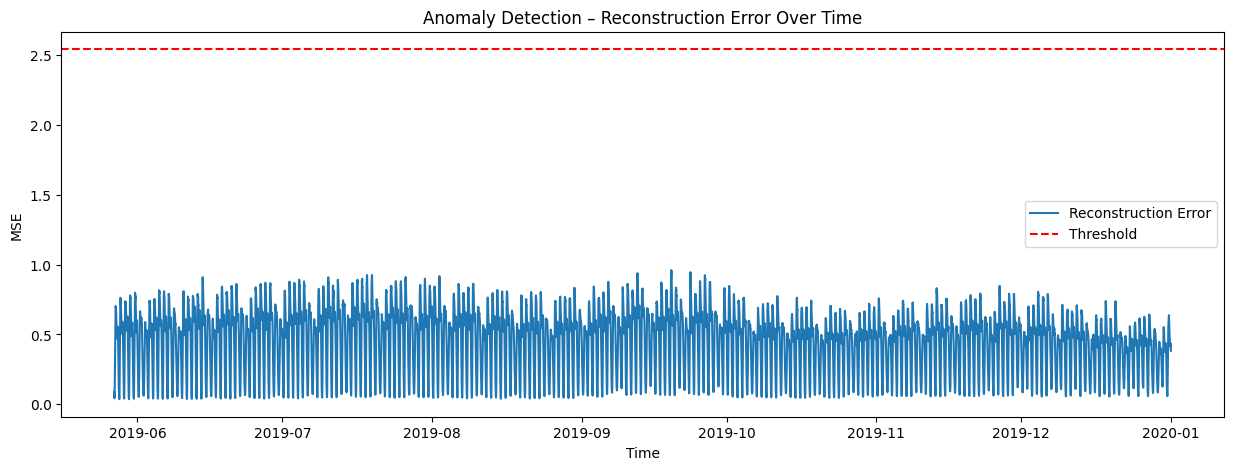

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(aligned_timestamps, test_mse, label="Reconstruction Error")
plt.axhline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Time")
plt.ylabel("MSE")
plt.title("Anomaly Detection – Reconstruction Error Over Time")
plt.legend()
plt.show()
